**AMIGOS FACIAL VIDEOS**

# **Processing Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from skimage import feature, color, io
from skimage.feature import hog
# import mediapipe as mp
import random
import pickle

## **Face Detection and Annonation**

In [ ]:
# Initialize MediaPipe Face Detection
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

def video_to_annotated_frames(output_path, video_path):
    # Open the video
    video_capture = cv2.VideoCapture(video_path)
    # Create directory to save frames
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Initialize frame count
    frame_count = 0
    # Read first frame
    success, frame = video_capture.read()

    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        while success:
            # Save frame as JPEG file
            if frame_count % 10 == 0:
                # Convert frame to RGB
                rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                # Detect faces in the image using MediaPipe
                results = face_detection.process(rgb_frame)

                if results.detections:
                    for detection in results.detections:
                        bboxC = detection.location_data.relative_bounding_box
                        ih, iw, _ = frame.shape
                        x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)

                        # Adjust the bounding box to include the forehead, ears, and chin
                        top_margin = int(0.3 * h)  # Increase this value to include more forehead
                        side_margin = int(0.1 * w)  # Increase this value to include ears
                        bottom_margin = int(0.1 * h)  # Increase this value to include more chin

                        x = max(0, x - side_margin)
                        y = max(0, y - top_margin)
                        w = min(iw, w + 2 * side_margin)
                        h = min(ih, h + top_margin + bottom_margin)

                        # Crop the image to the face region
                        face_image = frame[y:y+h, x:x+w]
                        # Resize the face region to 200x200 pixels
                        resized_face = cv2.resize(face_image, (200, 200))

                        trail_number = os.path.splitext(os.path.basename(video_path))[0]
                        cv2.imwrite(os.path.join(output_path, f"frame_{frame_count}_{trail_number}.jpg"), resized_face)
            # Read next frame
            success, frame = video_capture.read()
            # Increment frame count
            frame_count += 1
    # Release video capture object
    video_capture.release()

In [ ]:
folder_path = "D:/AMIGOS/Processing/Exp1_P02_face"
templist = []

# List all files in the folder
files = [name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))]
for filename in files:
    # Construct video_path with .mov extension
    video_path = os.path.join(folder_path, filename)
    output_path = folder_path + "/" + os.path.splitext(filename)[0]  # Assuming you want to use the file name without extension as output path

    # Check if the file is a video file
    if filename.lower().endswith(('.mov', '.mp4', '.avi', '.mkv')):
        # Call your function here with video_path and output_path
        video_to_annotated_frames(output_path, video_path)
        print('Frames Annotated and Saved: ', filename)
        templist.append(filename)
print('DONE')

## **Frames to Vectors**

In [ ]:
folder_path = "/content/drive/MyDrive/AMIGOS/Processing/Exp2_L06_Group_N04_face"
# folder_path = "D://AMIGOS//Processing//Exp1_P11_face"

In [ ]:
# Function to annotate and convert an image to a vector
def vectorize(image_path):
    # Read the image
    image = cv2.imread(image_path)
    vector = []
    # Convert the annotated image to a vector (flattened array of pixel values)
    vector = image.flatten()
    return vector

def extract_frame_number(filename):
    match = re.search(r'frame_(\d+)_', filename)
    return int(match.group(1)) if match else -1

# Paths
main_folder_path = folder_path
output_folder_path = main_folder_path.replace('/Processing', '', 1) + "/Annotated_Vectors_CSV"
# output_folder_path = main_folder_path.replace("D:", "/content/drive/MyDrive").replace("/Processing", "") + "/Annotated_Vectors_CSV"

In [ ]:
templist2 = []

In [ ]:
# Ensure the output folder exists
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# Iterate through each subfolder in the main folder
for subfolder in os.listdir(main_folder_path):
    subfolder_path = os.path.join(main_folder_path, subfolder)
    #if os.path.isdir(subfolder_path) and subfolder_path != os.pathoutput_folder_path:
    if os.path.isdir(subfolder_path) and subfolder != os.path.basename(output_folder_path):
        vectors = []
        # Get list of files in the subfolder and sort them based on frame number
        files = [file for file in os.listdir(subfolder_path) if file.endswith(".jpg")]
        files.sort(key=extract_frame_number)
        for file in files:
            file_path = os.path.join(subfolder_path, file)

            # Annotate and vectorize the image
            vector = vectorize(file_path)
            vectors.append(vector)

        # Find the maximum length of vectors
        if vectors:  # Ensure there are vectors to process
            max_length = max(len(vector) for vector in vectors)
            # Pad vectors to ensure they are of the same length
            padded_vectors = [np.pad(vector, (0, max_length - len(vector)), 'constant') for vector in vectors]
            # Convert list of padded vectors to a NumPy array
            vectors_array = np.array(padded_vectors)

        # Save the vectors to a CSV file
        output_file_path = os.path.join(output_folder_path, f"{subfolder}_annotated.csv")
        np.savetxt(output_file_path, vectors_array, delimiter=",")
        print("Annotated vectors saved:", subfolder)
        templist2.append(subfolder)
print('DONE')

In [ ]:
len(templist2)

0

## **HOG Features**

In [ ]:
folder_path = "/content/drive/MyDrive/AMIGOS/Processing/Exp1_P01_face"
# folder_path = "D://AMIGOS//Processing//Exp1_P11_face"

In [ ]:
main_folder_path = folder_path
output_folder_path = main_folder_path.replace('/Processing', '', 1) + "/Annotated_Vectors_CSV"
# output_folder_path = main_folder_path.replace("D:", "/content/drive/MyDrive").replace("/Processing", "") + "/Annotated_Vectors_CSV"

In [ ]:
def extract_hog_features(image_vector, image_shape):
    image = image_vector.reshape(image_shape).astype('uint8')
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_features, hog_image = hog(gray_image, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True)
    return hog_features, hog_image

In [ ]:
templist3 = []
"""
templist3 = [name for name in os.listdir('/content/drive/MyDrive/AMIGOS/Exp1_P14_face/HOG_Features_CSV')]
def get_prefix_up_to_third_underscore(filename):
    parts = filename.split('_')
    return '_'.join(parts[:3])
# Extract parts up to the third underscore for templist3
templist3_prefixes = [get_prefix_up_to_third_underscore(name) for name in templist3]
"""

"\ntemplist3 = [name for name in os.listdir('/content/drive/MyDrive/AMIGOS/Exp1_P14_face/HOG_Features_CSV')]\ndef get_prefix_up_to_third_underscore(filename):\n    parts = filename.split('_')\n    return '_'.join(parts[:3])\n# Extract parts up to the third underscore for templist3\ntemplist3_prefixes = [get_prefix_up_to_third_underscore(name) for name in templist3]\n"

In [ ]:
# Paths
annotated_vectors_folder = output_folder_path
hog_features_folder = output_folder_path.replace('/Annotated_Vectors_CSV', '', 1) + '/HOG_Features_CSV'

# Ensure the HOG features folder exists
if not os.path.exists(hog_features_folder):
    os.makedirs(hog_features_folder)

# List to store random original and HOG images for display
original_images = []
hog_images = []

# Iterate through each annotated CSV file
for csv_file in os.listdir(annotated_vectors_folder):
    # Extract part up to the third underscore for csv_file
    # csv_file_prefix = get_prefix_up_to_third_underscore(csv_file)
    if csv_file.endswith("_annotated.csv"): # and csv_file_prefix not in templist3_prefixes
        csv_path = os.path.join(annotated_vectors_folder, csv_file)

        # Load the annotated vectors
        vectors_array = np.loadtxt(csv_path, delimiter=",")

        # Extract HOG features for each vector
        hog_features_list = []
        for vector in vectors_array:
            height = int(np.sqrt(len(vector) // 3))
            width = height
            image_shape = (height, width, 3)
            hog_features, hog_image = extract_hog_features(vector, image_shape)
            hog_features_list.append(hog_features)

            # Store the original and HOG images for display
            if random.random() < 0.01:  # Randomly select images for display (adjust probability as needed)
                original_image = vector.reshape(image_shape).astype('uint8')
                original_images.append(original_image)
                hog_images.append(hog_image)

        # Convert HOG features list to a NumPy array
        hog_features_array = np.array(hog_features_list)

        # Save the HOG features to a new CSV file with the updated name
        new_csv_file = csv_file.replace("_annotated", "_HOG")
        new_csv_path = os.path.join(hog_features_folder, new_csv_file)
        np.savetxt(new_csv_path, hog_features_array, delimiter=",")

        print("HOG feature extracted and saved: ", new_csv_file)
        templist3.append(csv_file)
print('DONE')

HOG feature extracted and saved:  P1_5_face_HOG.csv
HOG feature extracted and saved:  P1_4_face_HOG.csv
HOG feature extracted and saved:  P1_9_face_HOG.csv
HOG feature extracted and saved:  P1_10_face_HOG.csv
HOG feature extracted and saved:  P1_13_face_HOG.csv
HOG feature extracted and saved:  P1_19_face_HOG.csv
HOG feature extracted and saved:  P1_20_face_HOG.csv
HOG feature extracted and saved:  P1_18_face_HOG.csv
HOG feature extracted and saved:  P1_30_face_HOG.csv
HOG feature extracted and saved:  P1_23_face_HOG.csv
HOG feature extracted and saved:  P1_31_face_HOG.csv
HOG feature extracted and saved:  P1_34_face_HOG.csv
HOG feature extracted and saved:  P1_58_face_HOG.csv
HOG feature extracted and saved:  P1_36_face_HOG.csv
HOG feature extracted and saved:  P1_138_face_HOG.csv
HOG feature extracted and saved:  P1_80_face_HOG.csv
DONE


In [ ]:
len(templist3)

16

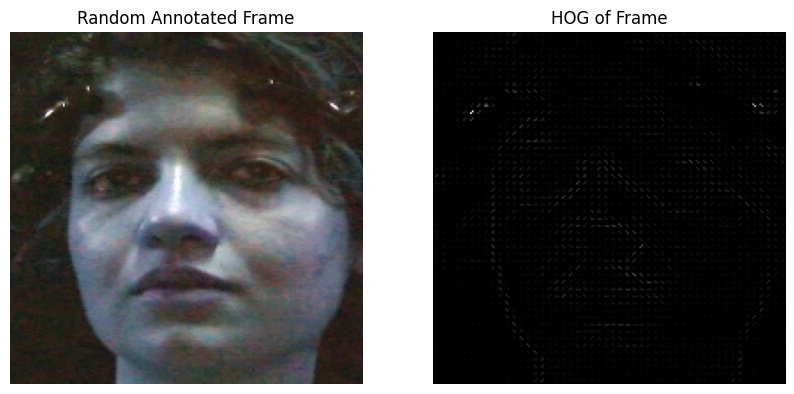

In [ ]:
# Display a random original and HOG image
if original_images and hog_images:
    #for random_index in range(len(original_images)):
    random_index = random.randint(0, len(original_images) - 1)
    random_original_image = original_images[random_index]
    random_hog_image = hog_images[random_index]
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(random_original_image)
    plt.title('Random Annotated Frame')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(random_hog_image, cmap='gray')
    plt.title('HOG of Frame')
    plt.axis('off')
    plt.show()

# **Combining HOG Features and Making DF**

In [ ]:
# Paths to folders and files
folder_path = "/content/drive/MyDrive/AMIGOS/Exp1_P40_face/HOG_Features_CSV"  # Folder containing the CSV files
excel_path = "/content/drive/MyDrive/AMIGOS/labels.xlsx"  # Path to Excel file with labels

# Load the Excel file containing labels
df_labels = pd.read_excel(excel_path)

## **Combine through DataFrames**

In [ ]:
# Initialize an empty DataFrame to hold all the processed data
final_df = pd.DataFrame()

In [ ]:
# Iterate through each CSV file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        # Construct the full file path
        csv_file_path = os.path.join(folder_path, filename)

        # Load the CSV file
        hog_features = pd.read_csv(csv_file_path, header=None)

        # Get the number of frames
        num_frames = hog_features.shape[0]
        # Calculate the number of frames per group (100 groups)
        frames_per_group = num_frames // 100

        # Initialize the result array
        result = np.zeros((100, 128))

        # Loop through each group
        for i in range(100):
            start_idx = i * frames_per_group
            end_idx = (i + 1) * frames_per_group
            group = hog_features.iloc[start_idx:end_idx, :]
            result[i, :] = np.mean(group, axis=0)

        # Flatten the result array into 2 rows
        flattened_result = np.zeros((2, result.shape[1] * 50))
        flattened_result[0, :] = result[:50, :].flatten()
        flattened_result[1, :] = result[50:, :].flatten()

        # Create a DataFrame from the flattened array
        df = pd.DataFrame(flattened_result)
        # Assign column names as Feature1, Feature2, ..., Feature12800
        df.columns = [f"Feature{i+1}" for i in range(flattened_result.shape[1])]
        print(df.shape)

        # Extract UserID and VideoID from the filename
        parts = filename.split('_')
        user_id = parts[0][1:]  # P1 -> 1
        video_id = parts[1]  # 4

        # Convert UserID and VideoID to match the format in Excel (strip quotes)
        user_id = int(user_id)
        video_id = str(video_id)

        # Find the matching row in the Excel file
        matching_row = df_labels[(df_labels['UserID'] == user_id) & (df_labels['VideoID'].str.strip("'") == video_id)]

        if not matching_row.empty:
            # Drop the UserID and VideoID columns and get the rest as labels
            labels = matching_row.drop(columns=['UserID', 'VideoID'])

            # Append each label column with its name from the Excel file to the CSV
            for column in labels.columns:
                df[column] = labels[column].values[0]

            print(f"Labels successfully appended to {filename}")
        else:
            print(f"No match found for UserID: {user_id}, VideoID: {video_id}")

        # Append the processed DataFrame to the final DataFrame
        final_df = pd.concat([final_df, df], ignore_index=True)

In [ ]:
# Save the final DataFrame to a CSV file (if needed)
# output_file = folder_path.replace("HOG_Features_CSV", "HOG_Features_Labeled_2.csv")
# final_df.to_csv(output_file, index=False)
# print(f"All CSV files processed and combined into {output_file}")
# print(final_df.shape)
# final_df.head(5)

In [ ]:
# Set the main folder path
main_folder_path = "/content/drive/MyDrive/AMIGOS/"

In [ ]:
mega_df = pd.DataFrame()

In [ ]:
# Iterate through each subfolder in the main folder
for subfolder in os.listdir(main_folder_path):
    subfolder_path = os.path.join(main_folder_path, subfolder)
    # Check if the subfolder is a directory
    if os.path.isdir(subfolder_path):
        # Iterate through each file in the subfolder
        for filename in os.listdir(subfolder_path):
            # Check if the file ends with ".csv"
            if filename.endswith("_2.csv"):
                print(filename)
                # Load the CSV file into a pandas dataframe
                filepath = os.path.join(subfolder_path, filename)
                df = pd.read_csv(filepath)

                # Concatenate all the dataframes into a single dataframe
                mega_df = pd.concat([mega_df, df], ignore_index=True)

In [ ]:
mega_df

In [ ]:
'''
Save Mega DF to Drive

'''

# mega_df.to_csv('/content/drive/MyDrive/AMIGOS/Mega_DF_2.csv', index=False)